# TDM (Tree-based Deep Model) 推荐系统分析

## 1. TDM 算法简介

**TDM (Tree-based Deep Model)** 是阿里巴巴提出的一种基于树结构的深度学习推荐算法，发表于 KDD 2018。

### 核心思想
- 将海量物品组织成一棵层次化的树结构
- 通过从粗到细的方式（coarse-to-fine）进行用户兴趣预测
- 从树的根节点向下遍历，逐层决策，最终找到用户感兴趣的物品
- 时间复杂度从 O(N) 降低到 O(log N)，其中 N 是物品库大小

### 主要优势
1. **高效检索**: 对于亿级物品库，可以在毫秒级完成推荐
2. **表达能力强**: 可以使用复杂的深度神经网络建模用户-物品交互
3. **联合学习**: 树结构和推荐模型可以联合训练优化

---

## 2. 数据集分析

我们来看看 `data_filtered.csv` 数据集的结构，以及它如何适配 TDM 算法。

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import os

# 读取数据 - 从 user_shards 文件夹加载一个分片（建模阶段足够使用）
print("正在加载 user_shards 数据...")

# 只加载第一个分片用于建模
shard_file = 'user_shards/shard_00.csv'
df = pd.read_csv(shard_file, header=None, 
                 names=['user_id', 'item_id', 'category_id', 'behavior', 'timestamp'])

print(f"加载完成! 数据量: {len(df):,} 条记录")
print(f"数据集列: {df.columns.tolist()}")
df.head(10)

正在加载 user_shards 数据...
加载完成! 数据量: 9,980,307 条记录
数据集列: ['user_id', 'item_id', 'category_id', 'behavior', 'timestamp']


,user_id,item_id,category_id,behavior,timestamp
0,100,4572582,2188684,pv,1511550516
1,100,2971043,4869428,pv,1511550600
2,100,2379198,4869428,pv,1511550806
3,100,2971043,4869428,pv,1511550885
4,100,1220136,4869428,pv,1511550908
5,100,2518420,3425094,pv,1511551443
6,100,3763048,3425094,pv,1511551450
7,100,2518420,3425094,pv,1511551495
8,100,1953042,3425094,pv,1511551619
9,100,3763048,3425094,fav,1511551860


In [2]:
# 数据统计概览
print("=" * 60)
print("数据集基本统计")
print("=" * 60)

n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_categories = df['category_id'].nunique()
n_interactions = len(df)

print(f"用户数量: {n_users:,}")
print(f"物品数量: {n_items:,}")
print(f"类目数量: {n_categories:,}")
print(f"交互记录: {n_interactions:,}")
print(f"数据稀疏度: {1 - n_interactions / (n_users * n_items):.6f}")

print("\n行为类型分布:")
behavior_counts = df['behavior'].value_counts()
for behavior, count in behavior_counts.items():
    print(f"  {behavior}: {count:,} ({count/len(df)*100:.2f}%)")

数据集基本统计
用户数量: 98,767
物品数量: 1,588,705
类目数量: 8,076
交互记录: 9,980,307
数据稀疏度: 0.999936

行为类型分布:
  pv: 8,938,121 (89.56%)
  cart: 553,595 (5.55%)
  fav: 287,593 (2.88%)
  buy: 200,998 (2.01%)


User-Item Interaction Analysis (Full Data)

User Statistics:
  Total Users: 98,767
  Mean Interactions: 101.0
  Median: 75
  Max: 820

Item Statistics:
  Total Items: 1,588,705
  Mean Interactions: 6.3
  Median: 2
  Max: 3,298


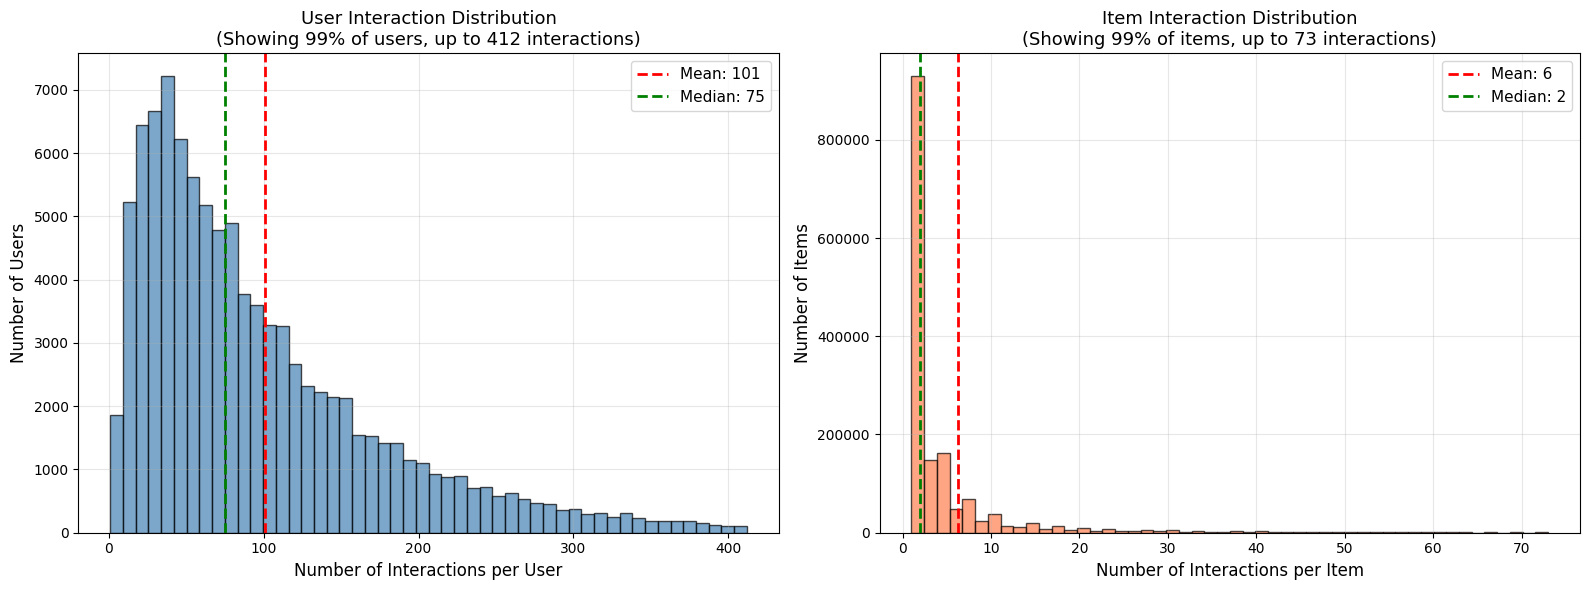


Building Interaction Heatmap with User/Item Counts...

User Decile Groups (by interaction count):
  Group 0: 10,233 users (interactions: 1-21)
  Group 1: 9,966 users (interactions: 22-33)
  Group 2: 9,601 users (interactions: 34-45)
  Group 3: 10,135 users (interactions: 46-59)
  Group 4: 9,861 users (interactions: 60-75)
  Group 5: 9,500 users (interactions: 76-94)
  Group 6: 10,073 users (interactions: 95-120)
  Group 7: 9,680 users (interactions: 121-155)
  Group 8: 9,887 users (interactions: 156-217)
  Group 9: 9,831 users (interactions: 218-820)

Item Decile Groups (by interaction count):
  Group 0: 929,905 items (interactions: 1-2)
  Group 1: 147,728 items (interactions: 3-3)
  Group 2: 95,364 items (interactions: 4-4)
  Group 3: 115,404 items (interactions: 5-6)
  Group 4: 144,050 items (interactions: 7-12)
  Group 5: 156,254 items (interactions: 13-3298)


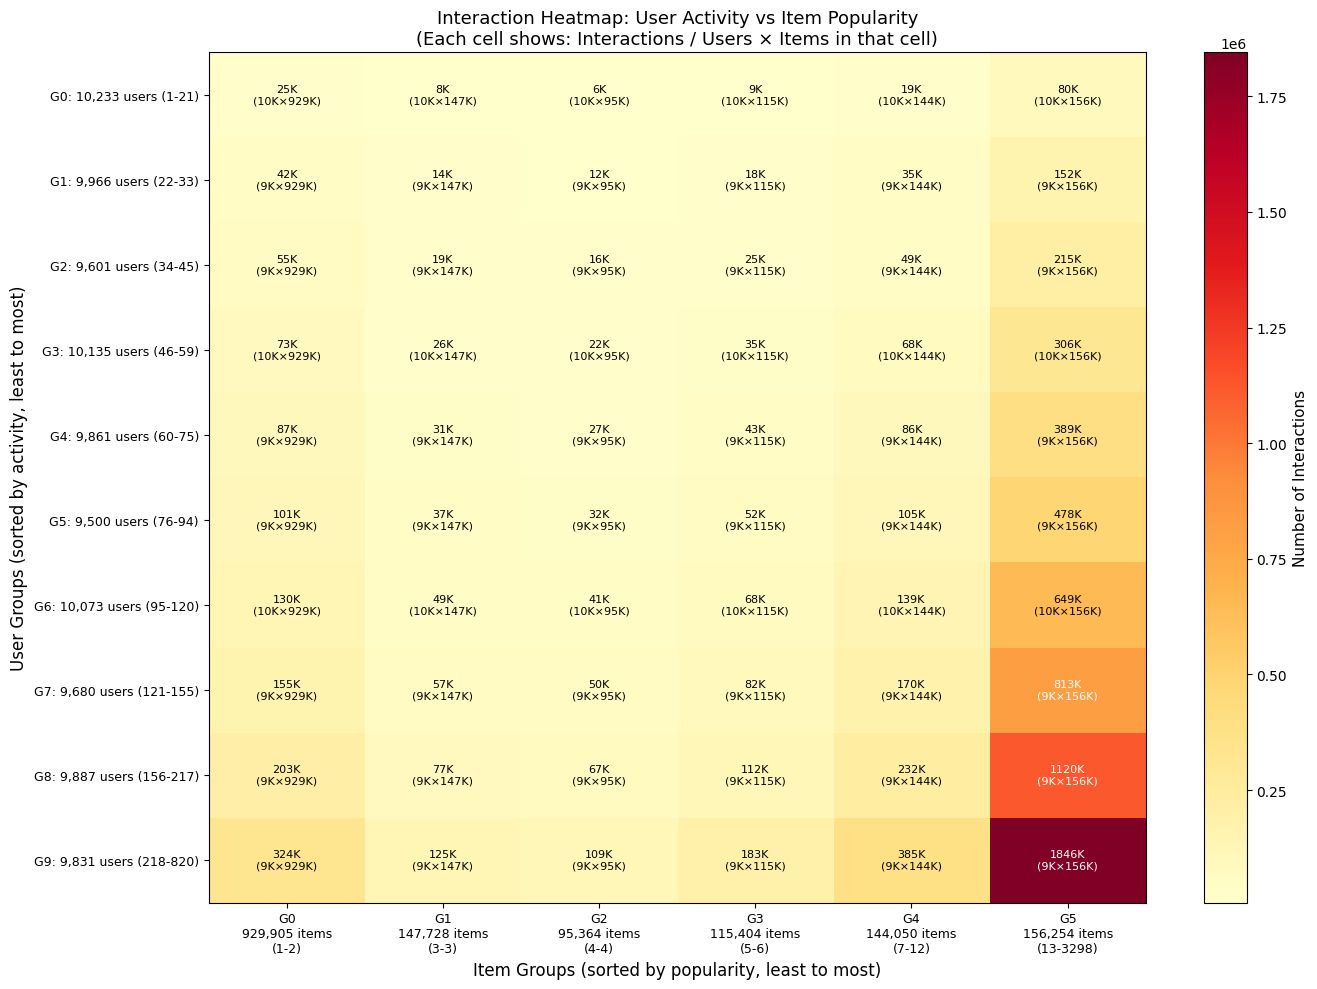

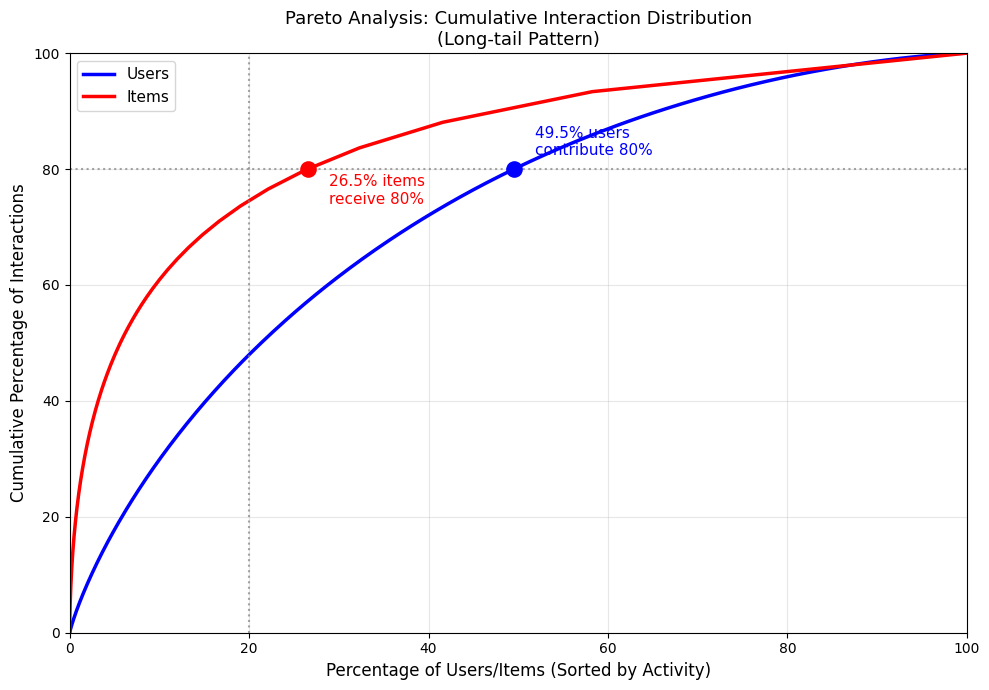


Key Insights from Full Data Analysis

📊 Pareto Analysis:
   - Top 49.5% of users contribute 80% of all interactions
   - Top 26.5% of items receive 80% of all interactions

📈 Sparsity: 0.999936
   (Only 0.0064% of user-item pairs have interactions)

💡 This long-tail distribution is why TDM's tree structure is effective:
   - Popular items cluster near root for quick access
   - Long-tail items organized in deeper branches


In [3]:
# 全量数据交互分析可视化
# 使用分组聚合的方式展示所有用户和物品的交互模式

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("=" * 60)
print("User-Item Interaction Analysis (Full Data)")
print("=" * 60)

# 计算每个用户和物品的交互次数
user_interaction_counts = df.groupby('user_id').size()
item_interaction_counts = df.groupby('item_id').size()

print(f"\nUser Statistics:")
print(f"  Total Users: {len(user_interaction_counts):,}")
print(f"  Mean Interactions: {user_interaction_counts.mean():.1f}")
print(f"  Median: {user_interaction_counts.median():.0f}")
print(f"  Max: {user_interaction_counts.max():,}")

print(f"\nItem Statistics:")
print(f"  Total Items: {len(item_interaction_counts):,}")
print(f"  Mean Interactions: {item_interaction_counts.mean():.1f}")
print(f"  Median: {item_interaction_counts.median():.0f}")
print(f"  Max: {item_interaction_counts.max():,}")

# ========== 第一部分: 用户和物品交互分布 (线性刻度，更大的图) ==========
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))

# 图1: 用户交互数分布 (线性刻度)
ax1 = axes1[0]
# 限制x轴范围到99%分位数，避免极端值拉伸图形
user_99pct = int(user_interaction_counts.quantile(0.99))
ax1.hist(user_interaction_counts[user_interaction_counts <= user_99pct], 
         bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Number of Interactions per User', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.set_title(f'User Interaction Distribution\n(Showing 99% of users, up to {user_99pct} interactions)', fontsize=13)
ax1.grid(True, alpha=0.3)

# 标注关键统计量
ax1.axvline(user_interaction_counts.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {user_interaction_counts.mean():.0f}')
ax1.axvline(user_interaction_counts.median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median: {user_interaction_counts.median():.0f}')
ax1.legend(fontsize=11)

# 图2: 物品交互数分布 (线性刻度)
ax2 = axes1[1]
item_99pct = int(item_interaction_counts.quantile(0.99))
ax2.hist(item_interaction_counts[item_interaction_counts <= item_99pct], 
         bins=50, edgecolor='black', alpha=0.7, color='coral')
ax2.set_xlabel('Number of Interactions per Item', fontsize=12)
ax2.set_ylabel('Number of Items', fontsize=12)
ax2.set_title(f'Item Interaction Distribution\n(Showing 99% of items, up to {item_99pct} interactions)', fontsize=13)
ax2.grid(True, alpha=0.3)

ax2.axvline(item_interaction_counts.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {item_interaction_counts.mean():.0f}')
ax2.axvline(item_interaction_counts.median(), color='green', linestyle='--', linewidth=2,
            label=f'Median: {item_interaction_counts.median():.0f}')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('sampled_data/distribution_linear.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== 第二部分: 交互热力图 (显示用户数、物品数、交互数) ==========
print("\n" + "=" * 60)
print("Building Interaction Heatmap with User/Item Counts...")
print("=" * 60)

# 将用户按交互数分成10组
user_bins = pd.qcut(user_interaction_counts, q=10, labels=False, duplicates='drop')
user_bin_ranges = pd.qcut(user_interaction_counts, q=10, duplicates='drop')

# 将物品按交互数分成10组  
item_bins = pd.qcut(item_interaction_counts, q=10, labels=False, duplicates='drop')
item_bin_ranges = pd.qcut(item_interaction_counts, q=10, duplicates='drop')

# 统计每个分组的用户数和物品数
user_bin_counts = user_bins.value_counts().sort_index()
item_bin_counts = item_bins.value_counts().sort_index()

# 获取每个分组的交互数范围
user_bin_range_strs = [f"{int(cat.left)+1}-{int(cat.right)}" for cat in sorted(user_bin_ranges.cat.categories)]
item_bin_range_strs = [f"{int(cat.left)+1}-{int(cat.right)}" for cat in sorted(item_bin_ranges.cat.categories)]

print(f"\nUser Decile Groups (by interaction count):")
for i, (cnt, rng) in enumerate(zip(user_bin_counts.values, user_bin_range_strs)):
    print(f"  Group {i}: {cnt:,} users (interactions: {rng})")

print(f"\nItem Decile Groups (by interaction count):")
for i, (cnt, rng) in enumerate(zip(item_bin_counts.values, item_bin_range_strs)):
    print(f"  Group {i}: {cnt:,} items (interactions: {rng})")

# 为每条交互记录分配用户组和物品组
df_temp = df.copy()
df_temp['user_bin'] = df_temp['user_id'].map(lambda x: user_bins.get(x, -1))
df_temp['item_bin'] = df_temp['item_id'].map(lambda x: item_bins.get(x, -1))

# 计算每个组合的交互数
heatmap_data = df_temp.groupby(['user_bin', 'item_bin']).size().unstack(fill_value=0)

# 创建更大的热力图
fig2, ax3 = plt.subplots(figsize=(14, 10))

im = ax3.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')

# 设置坐标轴标签 - 显示用户数和物品数
x_labels = [f"G{i}\n{item_bin_counts.values[i]:,} items\n({item_bin_range_strs[i]})" 
            for i in range(len(item_bin_counts))]
y_labels = [f"G{i}: {user_bin_counts.values[i]:,} users ({user_bin_range_strs[i]})" 
            for i in range(len(user_bin_counts))]

ax3.set_xticks(range(len(x_labels)))
ax3.set_xticklabels(x_labels, fontsize=9)
ax3.set_yticks(range(len(y_labels)))
ax3.set_yticklabels(y_labels, fontsize=9)

ax3.set_xlabel('Item Groups (sorted by popularity, least to most)', fontsize=12)
ax3.set_ylabel('User Groups (sorted by activity, least to most)', fontsize=12)
ax3.set_title('Interaction Heatmap: User Activity vs Item Popularity\n'
              '(Each cell shows: Interactions / Users × Items in that cell)', fontsize=13)

cbar = plt.colorbar(im, ax=ax3)
cbar.set_label('Number of Interactions', fontsize=11)

# 在热力图上显示详细信息：交互数 + 用户数 × 物品数
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        interactions = heatmap_data.values[i, j]
        n_users = user_bin_counts.values[i]
        n_items = item_bin_counts.values[j]
        
        if interactions > 0:
            color = 'white' if interactions > heatmap_data.values.max() * 0.4 else 'black'
            # 显示交互数
            int_str = f'{interactions/1000:.0f}K' if interactions >= 1000 else str(interactions)
            # 显示 用户数×物品数
            cell_str = f'{int_str}\n({n_users//1000}K×{n_items//1000}K)'
            ax3.text(j, i, cell_str, ha='center', va='center', fontsize=8, color=color)

plt.tight_layout()
plt.savefig('sampled_data/heatmap_detailed.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== 第三部分: 帕累托分析 ==========
fig3, ax4 = plt.subplots(figsize=(10, 7))

# 用户累积分布
user_sorted = np.sort(user_interaction_counts)[::-1]
user_cumsum = np.cumsum(user_sorted) / user_sorted.sum()
user_pct = np.arange(1, len(user_sorted) + 1) / len(user_sorted)

# 物品累积分布
item_sorted = np.sort(item_interaction_counts)[::-1]
item_cumsum = np.cumsum(item_sorted) / item_sorted.sum()
item_pct = np.arange(1, len(item_sorted) + 1) / len(item_sorted)

ax4.plot(user_pct * 100, user_cumsum * 100, 'b-', linewidth=2.5, label='Users')
ax4.plot(item_pct * 100, item_cumsum * 100, 'r-', linewidth=2.5, label='Items')

# 标注 80-20 规则
ax4.axhline(80, color='gray', linestyle=':', alpha=0.7)
ax4.axvline(20, color='gray', linestyle=':', alpha=0.7)

# 找到贡献80%交互的用户/物品比例
user_80 = user_pct[np.searchsorted(user_cumsum, 0.8)] * 100
item_80 = item_pct[np.searchsorted(item_cumsum, 0.8)] * 100

ax4.scatter([user_80], [80], color='blue', s=120, zorder=5)
ax4.scatter([item_80], [80], color='red', s=120, zorder=5)
ax4.annotate(f'{user_80:.1f}% users\ncontribute 80%', (user_80, 80), textcoords="offset points", 
             xytext=(15, 10), fontsize=11, color='blue')
ax4.annotate(f'{item_80:.1f}% items\nreceive 80%', (item_80, 80), textcoords="offset points", 
             xytext=(15, -25), fontsize=11, color='red')

ax4.set_xlabel('Percentage of Users/Items (Sorted by Activity)', fontsize=12)
ax4.set_ylabel('Cumulative Percentage of Interactions', fontsize=12)
ax4.set_title('Pareto Analysis: Cumulative Interaction Distribution\n(Long-tail Pattern)', fontsize=13)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 100)
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('sampled_data/pareto_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印关键洞察
print("\n" + "=" * 60)
print("Key Insights from Full Data Analysis")
print("=" * 60)
print(f"\n📊 Pareto Analysis:")
print(f"   - Top {user_80:.1f}% of users contribute 80% of all interactions")
print(f"   - Top {item_80:.1f}% of items receive 80% of all interactions")
print(f"\n📈 Sparsity: {1 - len(df) / (len(user_interaction_counts) * len(item_interaction_counts)):.6f}")
print(f"   (Only {len(df) / (len(user_interaction_counts) * len(item_interaction_counts)) * 100:.4f}% of user-item pairs have interactions)")
print("\n💡 This long-tail distribution is why TDM's tree structure is effective:")
print("   - Popular items cluster near root for quick access")
print("   - Long-tail items organized in deeper branches")

## 3. TDM 对您数据集的适用性分析

### 3.1 为什么 TDM 适合您的数据？

基于您的电商用户行为数据，TDM 有以下优势：

| 特征 | 您的数据 | TDM 优势 |
|------|----------|----------|
| **大规模物品库** | 数百万商品 | 树结构实现 O(log N) 检索 |
| **丰富的类目层次** | 多级类目 | 天然契合树结构建模 |
| **多种行为类型** | pv/fav/cart/buy | 支持隐式反馈序列建模 |
| **时间序列** | 有时间戳 | 支持用户兴趣演化建模 |

### 3.2 TDM 可以解决的问题

1. **召回阶段**: 从海量商品中高效找出候选集
2. **个性化推荐**: 根据用户历史行为预测兴趣
3. **冷启动优化**: 利用类目层次信息辅助新商品推荐

类目分析 - TDM 树结构的基础

类目总数: 8,076
平均每个类目商品数: 196.8
类目商品数中位数: 23.0

Top 10 类目 (按商品数):
 category_id  item_count
     2520377       32732
     4145813       32640
     2355072       28873
      982926       26634
     4756105       25669
     1320293       24349
     4801426       21599
     3002561       21412
     2885642       21108
     2465336       20077


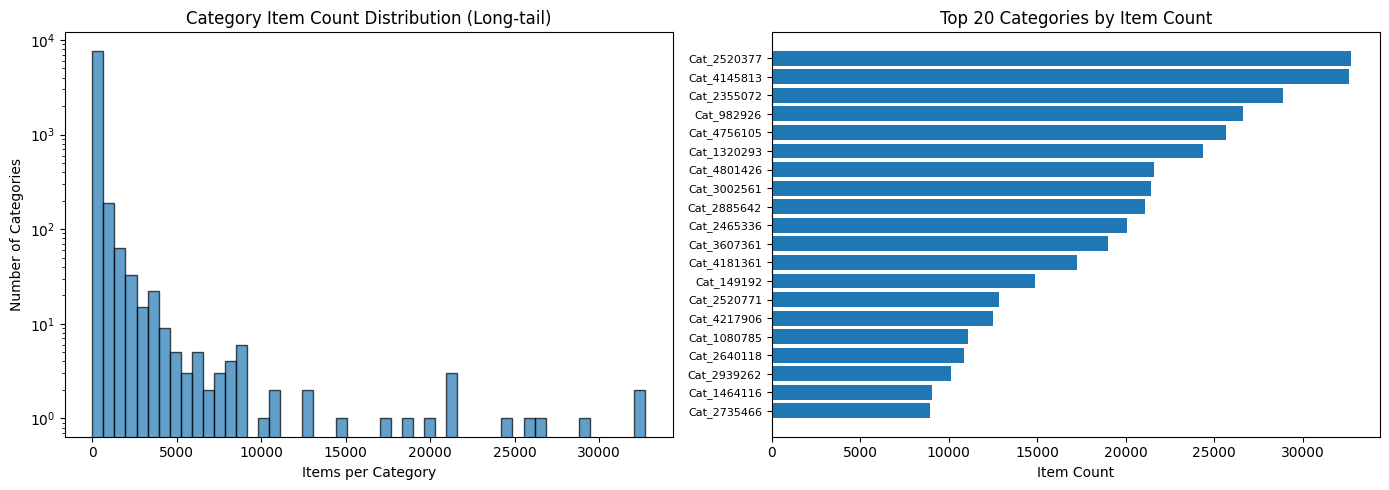


✅ 类目层次结构是构建 TDM 树的天然基础!


In [4]:
# 分析类目层次结构 - TDM 的关键输入
print("=" * 60)
print("类目分析 - TDM 树结构的基础")
print("=" * 60)

# 统计每个类目下的商品数
category_item_count = df.groupby('category_id')['item_id'].nunique().reset_index()
category_item_count.columns = ['category_id', 'item_count']
category_item_count = category_item_count.sort_values('item_count', ascending=False)

print(f"\n类目总数: {len(category_item_count):,}")
print(f"平均每个类目商品数: {category_item_count['item_count'].mean():.1f}")
print(f"类目商品数中位数: {category_item_count['item_count'].median():.1f}")

print("\nTop 10 类目 (按商品数):")
print(category_item_count.head(10).to_string(index=False))

# 类目分布可视化
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 类目商品数分布
axes[0].hist(category_item_count['item_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Items per Category')
axes[0].set_ylabel('Number of Categories')
axes[0].set_title('Category Item Count Distribution (Long-tail)')
axes[0].set_yscale('log')

# Top 20 类目
top_20 = category_item_count.head(20)
axes[1].barh(range(len(top_20)), top_20['item_count'].values)
axes[1].set_yticks(range(len(top_20)))
axes[1].set_yticklabels([f"Cat_{cid}" for cid in top_20['category_id'].values], fontsize=8)
axes[1].set_xlabel('Item Count')
axes[1].set_title('Top 20 Categories by Item Count')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✅ 类目层次结构是构建 TDM 树的天然基础!")

用户行为序列分析 - TDM 用户兴趣建模

用户行为序列长度统计:
  平均长度: 101.0
  中位数: 75.0
  最大长度: 820
  最小长度: 1

有购买行为的用户: 67,421 (685.8%)

用户兴趣多样性 (浏览类目数):
  平均: 24.4
  中位数: 21.0


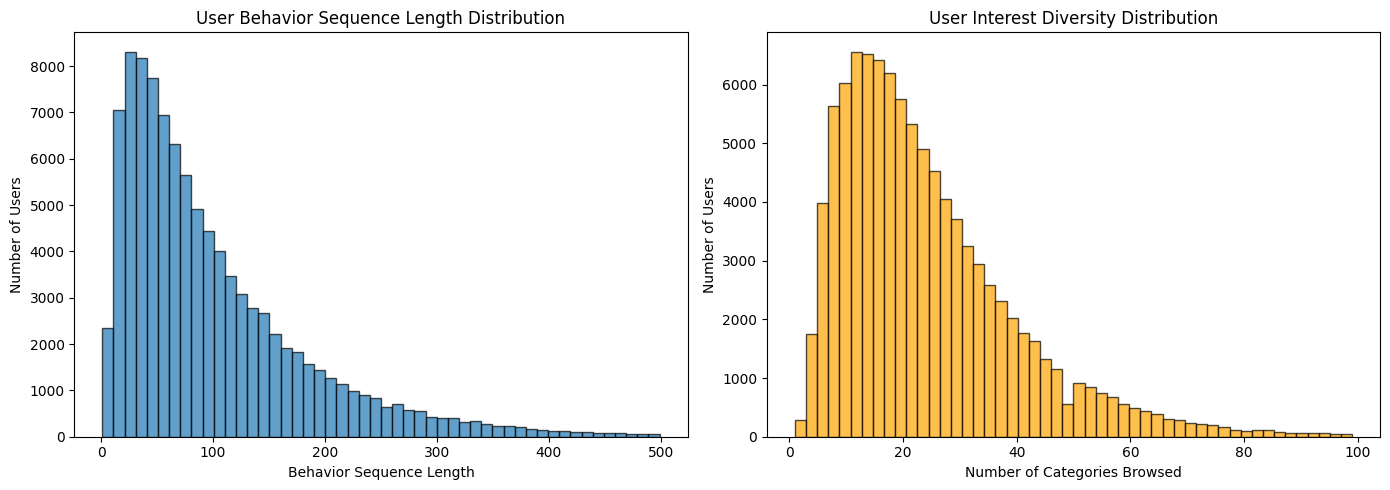


✅ 丰富的用户行为序列为 TDM 提供了良好的训练数据!


In [5]:
# 用户行为序列分析 - TDM 的用户兴趣建模基础
print("=" * 60)
print("用户行为序列分析 - TDM 用户兴趣建模")
print("=" * 60)

# 将时间戳转换为日期时间
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# 用户行为序列长度分布
user_seq_len = df.groupby('user_id').size()
print(f"\n用户行为序列长度统计:")
print(f"  平均长度: {user_seq_len.mean():.1f}")
print(f"  中位数: {user_seq_len.median():.1f}")
print(f"  最大长度: {user_seq_len.max():,}")
print(f"  最小长度: {user_seq_len.min()}")

# 用户购买行为分析
buy_df = df[df['behavior'] == 'buy']
users_with_buy = buy_df['user_id'].nunique()
print(f"\n有购买行为的用户: {users_with_buy:,} ({users_with_buy/n_users*100:.1f}%)")

# 用户兴趣多样性 (浏览类目数)
user_category_diversity = df.groupby('user_id')['category_id'].nunique()
print(f"\n用户兴趣多样性 (浏览类目数):")
print(f"  平均: {user_category_diversity.mean():.1f}")
print(f"  中位数: {user_category_diversity.median():.1f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 用户序列长度分布
axes[0].hist(user_seq_len[user_seq_len < 500], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Behavior Sequence Length')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('User Behavior Sequence Length Distribution')

# 用户类目多样性
axes[1].hist(user_category_diversity[user_category_diversity < 100], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Number of Categories Browsed')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('User Interest Diversity Distribution')

plt.tight_layout()
plt.show()

print("\n✅ 丰富的用户行为序列为 TDM 提供了良好的训练数据!")

## 4. TDM 数据预处理流程

要使用 TDM，需要将您的数据转换为以下格式：

### 4.1 所需数据格式

1. **物品层次结构文件** (`item_tree.txt`)
   - 定义物品在树中的位置
   - 可以基于类目构建初始树结构

2. **用户行为序列** (`train_data.txt`)
   - 格式: `user_id \t item_id_1,item_id_2,...,item_id_n \t label`
   - 正样本: 用户实际点击/购买的物品
   - 负样本: 随机采样的非交互物品

3. **物品 Embedding** (可选)
   - 用于初始化树结构的聚类

In [6]:
# 数据预处理示例 - 生成 TDM 训练数据格式

def prepare_tdm_data(df, min_seq_len=5, max_seq_len=100):
    """
    将电商行为数据转换为 TDM 训练格式
    
    Args:
        df: 原始行为数据
        min_seq_len: 最小序列长度
        max_seq_len: 最大序列长度
    
    Returns:
        训练数据 DataFrame
    """
    # 按用户和时间排序
    df_sorted = df.sort_values(['user_id', 'timestamp'])
    
    # 构建用户行为序列
    user_sequences = []
    
    for user_id, group in df_sorted.groupby('user_id'):
        items = group['item_id'].tolist()
        
        if len(items) < min_seq_len:
            continue
            
        # 截断过长序列
        if len(items) > max_seq_len:
            items = items[-max_seq_len:]
        
        # 滑动窗口生成训练样本
        for i in range(1, len(items)):
            history = items[:i]
            target = items[i]
            user_sequences.append({
                'user_id': user_id,
                'history': ','.join(map(str, history[-50:])),  # 最近50个历史
                'target_item': target,
                'label': 1  # 正样本
            })
    
    return pd.DataFrame(user_sequences)

# 生成示例训练数据 (使用样本数据)
print("生成 TDM 训练数据示例...")
sample_df = df.sample(n=min(100000, len(df)), random_state=42)
tdm_train_data = prepare_tdm_data(sample_df, min_seq_len=3, max_seq_len=50)

print(f"\n生成训练样本数: {len(tdm_train_data):,}")
print("\n训练数据示例:")
print(tdm_train_data.head(5).to_string())

# 保存示例数据
output_path = 'sampled_data/tdm_train_sample.csv'
tdm_train_data.head(10000).to_csv(output_path, index=False)
print(f"\n✅ 示例数据已保存到: {output_path}")

生成 TDM 训练数据示例...

生成训练样本数: 33,897

训练数据示例:
   user_id                 history  target_item  label
0       30                  960064      2154611      1
1       30          960064,2154611      2500705      1
2       30  960064,2154611,2500705      2444096      1
3      170                 3722189      1761080      1
4      170         3722189,1761080      4478172      1

✅ 示例数据已保存到: sampled_data/tdm_train_sample.csv


In [7]:
# 构建基于类目的初始树结构
print("=" * 60)
print("构建 TDM 树结构 (基于类目层次)")
print("=" * 60)

def build_category_tree(df):
    """
    基于类目构建初始的商品树结构
    
    树结构:
        Root
        ├── Category_1
        │   ├── Item_1
        │   ├── Item_2
        │   └── ...
        ├── Category_2
        │   ├── Item_3
        │   └── ...
        └── ...
    """
    # 获取物品-类目映射
    item_category = df.groupby('item_id')['category_id'].first().reset_index()
    
    # 构建树结构
    tree_structure = {}
    tree_structure['root'] = list(df['category_id'].unique())
    
    for cat_id in tree_structure['root']:
        items_in_cat = item_category[item_category['category_id'] == cat_id]['item_id'].tolist()
        tree_structure[f'cat_{cat_id}'] = items_in_cat
    
    return tree_structure, item_category

tree_structure, item_category = build_category_tree(df)

print(f"树结构统计:")
print(f"  根节点子节点数 (类目数): {len(tree_structure['root']):,}")
print(f"  叶子节点数 (物品数): {item_category['item_id'].nunique():,}")

# 计算树的理论高度
import math
n_items = item_category['item_id'].nunique()
avg_branching = len(tree_structure['root'])
theoretical_height = 2  # root -> category -> item
print(f"  当前树高度: {theoretical_height}")
print(f"  如果使用二叉树, 理论高度: {math.ceil(math.log2(n_items))}")

# 可视化树结构示例
print("\n树结构示例 (前3个类目):")
for i, cat_id in enumerate(tree_structure['root'][:3]):
    items = tree_structure[f'cat_{cat_id}'][:5]
    print(f"  ├── Category {cat_id}")
    for item in items:
        print(f"  │   ├── Item {item}")
    if len(tree_structure[f'cat_{cat_id}']) > 5:
        print(f"  │   └── ... ({len(tree_structure[f'cat_{cat_id}'])-5} more items)")

构建 TDM 树结构 (基于类目层次)
树结构统计:
  根节点子节点数 (类目数): 8,076
  叶子节点数 (物品数): 1,588,705
  当前树高度: 2
  如果使用二叉树, 理论高度: 21

树结构示例 (前3个类目):
  ├── Category 2188684
  │   ├── Item 13674
  │   ├── Item 42098
  │   ├── Item 71400
  │   ├── Item 81581
  │   ├── Item 96790
  │   └── ... (440 more items)
  ├── Category 4869428
  │   ├── Item 35511
  │   ├── Item 40188
  │   ├── Item 42188
  │   ├── Item 44493
  │   ├── Item 47402
  │   └── ... (740 more items)
  ├── Category 3425094
  │   ├── Item 9392
  │   ├── Item 39783
  │   ├── Item 55546
  │   ├── Item 67796
  │   ├── Item 82520
  │   └── ... (544 more items)


## 5. TDM 实现方案

### 5.1 原始 TDM (阿里巴巴 X-DeepLearning)
- 基于 XDL 框架, 需要特定环境配置
- 适合生产环境大规模部署

### 5.2 PyTorch 简化实现 (推荐入门)
下面是一个简化的 TDM 模型实现，可以在您的数据上进行实验：

In [8]:
# TDM 简化实现 (PyTorch GPU 版本)
# 注意: 这是一个教学版本，完整版需要更多优化

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 检查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

class SimpleTDMModel(nn.Module):
    """
    简化版 TDM 模型 (PyTorch 实现)
    
    核心思想:
    1. 用户历史行为 -> 用户兴趣向量
    2. 树节点 -> 节点向量
    3. 计算用户对每个节点的兴趣概率
    4. 从根节点向下遍历，选择高概率路径
    """
    
    def __init__(self, n_items, n_categories, embed_dim=64, hidden_dim=128):
        super().__init__()
        
        self.n_items = n_items
        self.n_categories = n_categories
        self.embed_dim = embed_dim
        
        # 物品和类目 Embedding (n_items+1 因为0是padding)
        self.item_embedding = nn.Embedding(n_items + 1, embed_dim, padding_idx=0)
        self.category_embedding = nn.Embedding(n_categories + 1, embed_dim, padding_idx=0)
        
        # 用户兴趣编码器 (使用 GRU 处理序列)
        self.user_encoder = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        # 节点分类器 (判断用户对节点的兴趣)
        self.node_classifier = nn.Sequential(
            nn.Linear(hidden_dim + embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def encode_user(self, item_seq):
        """编码用户历史行为序列"""
        item_embeds = self.item_embedding(item_seq)
        _, hidden = self.user_encoder(item_embeds)
        return hidden[-1]  # 取最后一层隐藏状态
    
    def predict_node(self, user_repr, node_embed):
        """预测用户对节点的兴趣概率"""
        combined = torch.cat([user_repr, node_embed], dim=-1)
        return self.node_classifier(combined)
    
    def forward(self, item_seq, target_items):
        """
        前向传播
        
        Args:
            item_seq: [batch, seq_len] 用户历史物品ID序列
            target_items: [batch] 目标物品ID
        
        Returns:
            用户对目标物品的兴趣概率
        """
        user_repr = self.encode_user(item_seq)
        target_embed = self.item_embedding(target_items)
        prob = self.predict_node(user_repr, target_embed)
        return prob.squeeze(-1)

# ========== 创建 ID 映射 (与后续训练单元格保持一致) ==========
print("\n创建 ID 映射...")

# 物品 ID 映射 (原始ID -> 连续索引 1,2,3,...)
unique_items = df['item_id'].unique()
item_id_to_idx = {item_id: idx + 1 for idx, item_id in enumerate(unique_items)}  # 0 留给 padding
idx_to_item_id = {idx: item_id for item_id, idx in item_id_to_idx.items()}

# 类目 ID 映射
unique_categories = df['category_id'].unique()
cat_id_to_idx = {cat_id: idx + 1 for idx, cat_id in enumerate(unique_categories)}  # 0 留给 padding
idx_to_cat_id = {idx: cat_id for cat_id, idx in cat_id_to_idx.items()}

# 映射后的数量
n_items_mapped = len(item_id_to_idx)
n_categories_mapped = len(cat_id_to_idx)

print(f"物品 ID 范围: 1 ~ {n_items_mapped}")
print(f"类目 ID 范围: 1 ~ {n_categories_mapped}")

# 创建模型 - 使用映射后的数量
print("\n" + "=" * 60)
print("TDM 模型结构 (PyTorch GPU 版本)")
print("=" * 60)

model = SimpleTDMModel(n_items=n_items_mapped, n_categories=n_categories_mapped, embed_dim=64, hidden_dim=128)
model = model.to(device)
print(model)

# 参数统计
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n总参数量: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")

# 演示前向传播
print("\n" + "=" * 60)
print("模型前向传播测试")
print("=" * 60)

# 创建测试数据 - 使用映射后的范围
batch_size = 32
seq_len = 20
test_seq = torch.randint(1, n_items_mapped + 1, (batch_size, seq_len)).to(device)
test_target = torch.randint(1, n_items_mapped + 1, (batch_size,)).to(device)

# 前向传播
with torch.no_grad():
    output = model(test_seq, test_target)
    print(f"输入序列形状: {test_seq.shape}")
    print(f"目标物品形状: {test_target.shape}")
    print(f"输出概率形状: {output.shape}")
    print(f"输出概率范围: [{output.min().item():.4f}, {output.max().item():.4f}]")

print("\n✅ PyTorch GPU 模型创建成功!")

使用设备: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU

创建 ID 映射...
物品 ID 范围: 1 ~ 1588705
类目 ID 范围: 1 ~ 8076

TDM 模型结构 (PyTorch GPU 版本)
SimpleTDMModel(
  (item_embedding): Embedding(1588706, 64, padding_idx=0)
  (category_embedding): Embedding(8077, 64, padding_idx=0)
  (user_encoder): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (node_classifier): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

总参数量: 102,392,513
可训练参数: 102,392,513

模型前向传播测试
输入序列形状: torch.Size([32, 20])
目标物品形状: torch.Size([32])
输出概率形状: torch.Size([32])
输出概率范围: [0.4384, 0.5669]

✅ PyTorch GPU 模型创建成功!


## 6. 总结与建议

### 6.1 TDM 对您数据集的帮助

| 方面 | 帮助程度 | 说明 |
|------|----------|------|
| **召回效率** | ⭐⭐⭐⭐⭐ | 从亿级商品库中毫秒级检索 |
| **推荐精度** | ⭐⭐⭐⭐ | 深度网络建模复杂用户兴趣 |
| **类目利用** | ⭐⭐⭐⭐⭐ | 天然利用类目层次信息 |
| **序列建模** | ⭐⭐⭐⭐ | 支持用户行为序列建模 |
| **冷启动** | ⭐⭐⭐ | 类目信息辅助新商品推荐 |

### 6.2 实施建议

1. **数据准备阶段**
   - 基于 `category_id` 构建初始树结构
   - 使用购买行为 (`buy`) 作为正样本
   - 使用浏览行为 (`pv`) 辅助训练

2. **模型选择**
   - 入门: 使用上述 PyTorch 简化版本
   - 进阶: 参考阿里 X-DeepLearning 原版实现
   - 生产: 考虑使用 TDM 的开源替代品如 MIND, SDM

3. **评估指标**
   - Recall@K: 召回率
   - NDCG@K: 排序质量
   - Hit Rate: 命中率

### 6.3 相关资源

- **论文**: [Learning Tree-based Deep Model for Recommender Systems (KDD 2018)](https://arxiv.org/abs/1801.02294)
- **代码**: [alibaba/x-deeplearning](https://github.com/alibaba/x-deeplearning)
- **后续工作**: JTM (Joint Tree Model), OTM (Optimal Tree Model)

## 7. TDM 模型训练

按照阿里 TDM 论文的核心思想，训练流程包括：

1. **构建层次化树结构** - 基于类目将商品组织成树
2. **层级负采样** - 在树的每一层采样负样本
3. **多任务学习** - 同时优化各层节点的分类任务
4. **Beam Search 推理** - 从根到叶逐层筛选候选

In [9]:
# TDM 训练数据集构建
# 按照阿里 TDM 的训练方式，构建包含层级负采样的训练数据

import torch
from torch.utils.data import Dataset, DataLoader
import random
from tqdm import tqdm

# ========== 关键修复：创建 ID 到连续索引的映射 ==========
print("创建 ID 映射...")

# 物品 ID 映射 (原始ID -> 连续索引 1,2,3,...)
unique_items = df['item_id'].unique()
item_id_to_idx = {item_id: idx + 1 for idx, item_id in enumerate(unique_items)}  # 0 留给 padding
idx_to_item_id = {idx: item_id for item_id, idx in item_id_to_idx.items()}

# 类目 ID 映射
unique_categories = df['category_id'].unique()
cat_id_to_idx = {cat_id: idx + 1 for idx, cat_id in enumerate(unique_categories)}  # 0 留给 padding
idx_to_cat_id = {idx: cat_id for cat_id, idx in cat_id_to_idx.items()}

print(f"物品 ID 范围: 1 ~ {len(item_id_to_idx)}")
print(f"类目 ID 范围: 1 ~ {len(cat_id_to_idx)}")

# 更新 n_items 和 n_categories 为映射后的数量
n_items_mapped = len(item_id_to_idx)
n_categories_mapped = len(cat_id_to_idx)
print(f"映射后物品数: {n_items_mapped}, 类目数: {n_categories_mapped}")

class TDMDataset(Dataset):
    """
    TDM 训练数据集
    
    核心思想：对于每个正样本（用户点击的物品），在树的每一层采样负样本
    - 第一层（类目层）：正样本是物品所属类目，负样本是其他类目
    - 第二层（物品层）：正样本是目标物品，负样本是同类目下的其他物品
    """
    
    def __init__(self, df, item_id_to_idx, cat_id_to_idx, seq_len=50, neg_samples=5):
        """
        Args:
            df: 用户行为数据
            item_id_to_idx: 物品ID到索引的映射
            cat_id_to_idx: 类目ID到索引的映射
            seq_len: 用户序列最大长度
            neg_samples: 每层负样本数量
        """
        self.seq_len = seq_len
        self.neg_samples = neg_samples
        self.item_id_to_idx = item_id_to_idx
        self.cat_id_to_idx = cat_id_to_idx
        
        # 获取所有类目和物品索引列表
        self.all_category_indices = list(cat_id_to_idx.values())
        self.all_item_indices = list(item_id_to_idx.values())
        
        # 构建物品索引到类目索引的映射
        self.item_idx_to_cat_idx = {}
        for item_id, cat_id in zip(item_category['item_id'], item_category['category_id']):
            if item_id in item_id_to_idx and cat_id in cat_id_to_idx:
                self.item_idx_to_cat_idx[item_id_to_idx[item_id]] = cat_id_to_idx[cat_id]
        
        # 构建类目索引到物品索引列表的映射
        self.cat_idx_to_item_indices = {}
        for item_idx, cat_idx in self.item_idx_to_cat_idx.items():
            if cat_idx not in self.cat_idx_to_item_indices:
                self.cat_idx_to_item_indices[cat_idx] = []
            self.cat_idx_to_item_indices[cat_idx].append(item_idx)
        
        # 构建用户序列
        print("构建用户行为序列...")
        self.samples = self._build_samples(df)
        print(f"构建完成，共 {len(self.samples)} 个训练样本")
    
    def _build_samples(self, df):
        """构建训练样本"""
        samples = []
        df_sorted = df.sort_values(['user_id', 'timestamp'])
        
        for user_id, group in tqdm(df_sorted.groupby('user_id'), desc="处理用户"):
            item_ids = group['item_id'].tolist()
            
            if len(item_ids) < 3:  # 序列太短跳过
                continue
            
            # 转换为索引
            item_indices = []
            for item_id in item_ids:
                if item_id in self.item_id_to_idx:
                    item_indices.append(self.item_id_to_idx[item_id])
            
            if len(item_indices) < 3:
                continue
            
            # 滑动窗口生成样本
            for i in range(2, len(item_indices)):
                history = item_indices[max(0, i - self.seq_len):i]
                target_item_idx = item_indices[i]
                
                # 获取目标物品的类目索引
                if target_item_idx not in self.item_idx_to_cat_idx:
                    continue
                
                target_cat_idx = self.item_idx_to_cat_idx[target_item_idx]
                
                samples.append({
                    'history': history,
                    'target_item_idx': target_item_idx,
                    'target_cat_idx': target_cat_idx
                })
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def _sample_negative_categories(self, positive_cat_idx, num_neg):
        """采样负类目索引"""
        neg_cats = []
        while len(neg_cats) < num_neg:
            cat_idx = random.choice(self.all_category_indices)
            if cat_idx != positive_cat_idx and cat_idx not in neg_cats:
                neg_cats.append(cat_idx)
        return neg_cats
    
    def _sample_negative_items(self, positive_item_idx, cat_idx, num_neg):
        """在同类目下采样负物品索引"""
        neg_items = []
        cat_items = self.cat_idx_to_item_indices.get(cat_idx, self.all_item_indices)
        
        attempts = 0
        while len(neg_items) < num_neg and attempts < num_neg * 3:
            if len(cat_items) > 1:
                item_idx = random.choice(cat_items)
            else:
                item_idx = random.choice(self.all_item_indices)
            
            if item_idx != positive_item_idx and item_idx not in neg_items:
                neg_items.append(item_idx)
            attempts += 1
        
        # 如果同类目物品不够，从全局采样补充
        while len(neg_items) < num_neg:
            item_idx = random.choice(self.all_item_indices)
            if item_idx != positive_item_idx and item_idx not in neg_items:
                neg_items.append(item_idx)
        
        return neg_items
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        history = sample['history']
        target_item_idx = sample['target_item_idx']
        target_cat_idx = sample['target_cat_idx']
        
        # Padding 历史序列
        if len(history) < self.seq_len:
            history = [0] * (self.seq_len - len(history)) + history
        else:
            history = history[-self.seq_len:]
        
        # 采样负样本
        neg_categories = self._sample_negative_categories(target_cat_idx, self.neg_samples)
        neg_items = self._sample_negative_items(target_item_idx, target_cat_idx, self.neg_samples)
        
        return {
            'history': torch.LongTensor(history),
            'target_item': torch.LongTensor([target_item_idx]),
            'target_category': torch.LongTensor([target_cat_idx]),
            'neg_items': torch.LongTensor(neg_items),
            'neg_categories': torch.LongTensor(neg_categories)
        }

# 为了加速训练，先用部分数据
sample_size = min(500000, len(df))
train_df = df.sample(n=sample_size, random_state=42)

# 创建数据集
dataset = TDMDataset(
    train_df, 
    item_id_to_idx,
    cat_id_to_idx,
    seq_len=50, 
    neg_samples=5
)

# 创建 DataLoader
train_loader = DataLoader(
    dataset, 
    batch_size=256, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

print(f"\n数据集大小: {len(dataset)}")
print(f"批次数: {len(train_loader)}")

创建 ID 映射...
物品 ID 范围: 1 ~ 1588705
类目 ID 范围: 1 ~ 8076
映射后物品数: 1588705, 类目数: 8076
构建用户行为序列...


处理用户: 100%|██████████| 88774/88774 [00:07<00:00, 11269.99it/s]

构建完成，共 335930 个训练样本

数据集大小: 335930
批次数: 1313


NameError: name 'eval_results_v2' is not defined

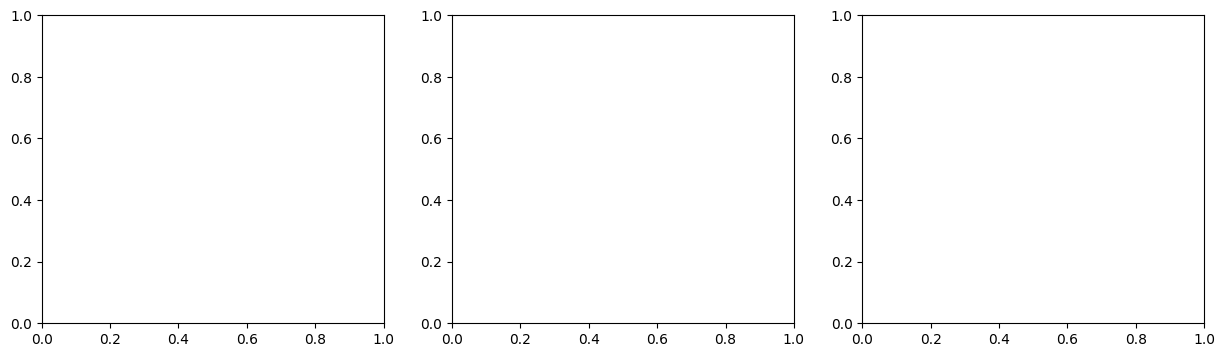

In [10]:
# 可视化对比
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

k_values = [5, 10, 20]
metrics_to_plot = ['Recall', 'HitRate', 'NDCG']
colors = ['steelblue', 'seagreen', 'coral']

for idx, (metric_name, color) in enumerate(zip(metrics_to_plot, colors)):
    values = [eval_results_v2[f'{metric_name}@{k}'] for k in k_values]
    
    axes[idx].bar(k_values, values, color=color, edgecolor='black', alpha=0.8)
    axes[idx].set_xlabel('K', fontsize=11)
    axes[idx].set_ylabel(metric_name, fontsize=11)
    axes[idx].set_title(f'{metric_name}@K (Time-Split + Strong Signals)', fontsize=12)
    axes[idx].set_xticks(k_values)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # 在柱子上标注数值
    for i, (k, v) in enumerate(zip(k_values, values)):
        axes[idx].text(k, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('sampled_data/tdm_evaluation_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 评估完成! 结果已保存到 sampled_data/tdm_evaluation_v2.png")

In [ ]:
# ========== 在测试集上评估（正确的时间序列评估） ==========
print("\n" + "=" * 60)
print("在测试集上评估（时间序列划分）")
print("=" * 60)

# 构建必要的映射
all_cat_indices_v2 = list(cat_id_to_idx_v2.values())

# 物品索引到类目索引的映射
item_idx_to_cat_idx_v2 = {}
for item_id, cat_id in zip(item_category_v2['item_id'], item_category_v2['category_id']):
    if item_id in item_id_to_idx_v2 and cat_id in cat_id_to_idx_v2:
        item_idx_to_cat_idx_v2[item_id_to_idx_v2[item_id]] = cat_id_to_idx_v2[cat_id]

# 类目索引到物品索引列表
cat_idx_to_item_indices_v2 = {}
for item_idx, cat_idx in item_idx_to_cat_idx_v2.items():
    if cat_idx not in cat_idx_to_item_indices_v2:
        cat_idx_to_item_indices_v2[cat_idx] = []
    cat_idx_to_item_indices_v2[cat_idx].append(item_idx)

print(f"映射构建完成")
print(f"  物品索引映射: {len(item_idx_to_cat_idx_v2):,}")
print(f"  类目索引映射: {len(cat_idx_to_item_indices_v2):,}")

def evaluate_model_timesplit(model, train_df, test_df, item_id_to_idx, all_cat_indices, 
                              cat_idx_to_item_indices, device, num_users=500, k_list=[5, 10, 20]):
    """
    基于时间划分的评估方法
    
    对于测试集中的每个用户：
    - 使用其训练集中的全部历史行为作为输入
    - 预测测试集中的行为
    """
    model.eval()
    
    metrics = defaultdict(list)
    
    # 获取测试集中有行为的用户
    test_users_set = set(test_df['user_id'].unique())
    train_users_set = set(train_df['user_id'].unique())
    
    # 只评估在训练集和测试集都有行为的用户
    valid_users = list(test_users_set & train_users_set)
    
    if len(valid_users) > num_users:
        valid_users = np.random.choice(valid_users, num_users, replace=False)
    
    print(f"评估 {len(valid_users)} 个用户 (训练集和测试集都有行为)...")
    
    for user_id in tqdm(valid_users, desc="评估中"):
        # 获取该用户的训练历史
        train_user_df = train_df[train_df['user_id'] == user_id].sort_values('timestamp')
        train_items = train_user_df['item_id'].tolist()
        
        # 转换为索引（跳过不在映射中的物品）
        train_history_indices = [item_id_to_idx[item_id] 
                                 for item_id in train_items 
                                 if item_id in item_id_to_idx]
        
        if len(train_history_indices) == 0:
            continue
        
        # 获取该用户的测试集真实行为
        test_user_df = test_df[test_df['user_id'] == user_id]
        test_items = test_user_df['item_id'].tolist()
        
        # 转换为索引
        ground_truth_indices = set([item_id_to_idx[item_id] 
                                    for item_id in test_items 
                                    if item_id in item_id_to_idx])
        
        if len(ground_truth_indices) == 0:
            continue
        
        # 推荐
        max_k = max(k_list)
        recommendations = tdm_beam_search(
            model, train_history_indices, all_cat_indices, cat_idx_to_item_indices,
            device, top_k_categories=30, top_k_items=max_k
        )
        
        rec_items = [item_idx for item_idx, _ in recommendations]
        
        # 计算各 K 值的指标
        for k in k_list:
            rec_k = rec_items[:k]
            
            # Recall@K
            hits = len(set(rec_k) & ground_truth_indices)
            recall = hits / len(ground_truth_indices) if len(ground_truth_indices) > 0 else 0
            metrics[f'Recall@{k}'].append(recall)
            
            # Hit Rate@K
            hit_rate = 1 if hits > 0 else 0
            metrics[f'HitRate@{k}'].append(hit_rate)
            
            # NDCG@K
            dcg = 0
            for i, item in enumerate(rec_k):
                if item in ground_truth_indices:
                    dcg += 1 / np.log2(i + 2)
            
            ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(k, len(ground_truth_indices))))
            ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
            metrics[f'NDCG@{k}'].append(ndcg)
    
    # 计算平均值
    results = {}
    for metric_name, values in metrics.items():
        results[metric_name] = np.mean(values)
    
    return results

# 运行评估
eval_results_v2 = evaluate_model_timesplit(
    tdm_model_v2, train_core, test_core, item_id_to_idx_v2, 
    all_cat_indices_v2, cat_idx_to_item_indices_v2, device,
    num_users=500, k_list=[5, 10, 20]
)

print("\n" + "=" * 60)
print("评估结果 (时间序列划分 + 强信号)")
print("=" * 60)
for metric, value in sorted(eval_results_v2.items()):
    print(f"  {metric}: {value:.4f}")
print("=" * 60)

# 对比旧结果
print("\n📊 性能对比:")
print("-" * 60)
print(f"{'指标':<15} {'旧方法':>12} {'新方法':>12} {'提升'}")
print("-" * 60)

if 'eval_results' in dir():
    for metric in ['Recall@10', 'HitRate@10', 'NDCG@10']:
        old_val = eval_results.get(metric, 0)
        new_val = eval_results_v2.get(metric, 0)
        improvement = ((new_val - old_val) / old_val * 100) if old_val > 0 else float('inf')
        
        if improvement == float('inf'):
            imp_str = "+∞"
        else:
            imp_str = f"+{improvement:.0f}%"
        
        print(f"{metric:<15} {old_val:>12.4f} {new_val:>12.4f} {imp_str}")
else:
    for metric in sorted(eval_results_v2.keys()):
        print(f"{metric:<15} {'N/A':>12} {eval_results_v2[metric]:>12.4f}")

print("-" * 60)

In [ ]:
# ========== 重新创建和训练模型 ==========
print("\n" + "=" * 60)
print("创建新模型（使用正确的数据维度）")
print("=" * 60)

tdm_model_v2 = TDMModelWithTree(
    n_items=n_items_v2,
    n_categories=n_categories_v2,
    embed_dim=64,
    hidden_dim=128
)
tdm_model_v2 = tdm_model_v2.to(device)

optimizer_v2 = optim.Adam(tdm_model_v2.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_v2 = optim.lr_scheduler.StepLR(optimizer_v2, step_size=2, gamma=0.5)

total_params = sum(p.numel() for p in tdm_model_v2.parameters())
print(f"模型参数量: {total_params:,}")
print(f"设备: {device}")

# 训练配置
num_epochs_v2 = 5
best_loss_v2 = float('inf')
history_losses_v2 = []

print("\n" + "=" * 60)
print("开始训练（正确的数据划分）")
print("=" * 60)
print(f"训练样本: {len(dataset_v2):,}")
print(f"批次大小: 256")
print(f"训练轮数: {num_epochs_v2}")
print("=" * 60)

start_time = time.time()

for epoch in range(1, num_epochs_v2 + 1):
    epoch_start = time.time()
    
    avg_loss, avg_cat_loss, avg_item_loss = train_epoch(
        tdm_model_v2, train_loader_v2, optimizer_v2, device, epoch
    )
    
    scheduler_v2.step()
    current_lr = scheduler_v2.get_last_lr()[0]
    
    epoch_time = time.time() - epoch_start
    
    history_losses_v2.append({
        'epoch': epoch,
        'loss': avg_loss,
        'cat_loss': avg_cat_loss,
        'item_loss': avg_item_loss
    })
    
    print(f"\nEpoch {epoch}/{num_epochs_v2}")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Category Loss: {avg_cat_loss:.4f}")
    print(f"  Item Loss: {avg_item_loss:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Time: {epoch_time:.1f}s")
    
    if avg_loss < best_loss_v2:
        best_loss_v2 = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': tdm_model_v2.state_dict(),
            'optimizer_state_dict': optimizer_v2.state_dict(),
            'loss': avg_loss,
        }, 'sampled_data/tdm_best_model_v2.pt')
        print(f"  ✅ 保存最佳模型 (loss: {best_loss_v2:.4f})")

total_time = time.time() - start_time
print("\n" + "=" * 60)
print(f"训练完成! 总耗时: {total_time/60:.1f} 分钟")
print(f"最佳损失: {best_loss_v2:.4f}")
print("=" * 60)

In [ ]:
# ========== 重新创建训练数据集（使用全部训练数据） ==========
print("\n" + "=" * 60)
print("创建新的训练数据集（时间划分 + 强信号 + 全部数据）")
print("=" * 60)

# 使用全部训练数据（不再采样）
dataset_v2 = TDMDataset(
    train_core,  # 使用全部训练数据
    item_id_to_idx_v2,
    cat_id_to_idx_v2,
    seq_len=50,
    neg_samples=5
)

train_loader_v2 = DataLoader(
    dataset_v2,
    batch_size=256,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

print(f"\n训练集大小: {len(dataset_v2):,} 个样本")
print(f"批次数: {len(train_loader_v2):,}")
print(f"每个 epoch 大约需要: {len(train_loader_v2) * 0.2:.0f}秒")

In [ ]:
# ========== 重新构建 ID 映射（基于训练集） ==========
print("\n" + "=" * 60)
print("重新构建 ID 映射")
print("=" * 60)

# 只基于训练集构建映射
unique_train_items = train_core['item_id'].unique()
unique_train_categories = train_core['category_id'].unique()

item_id_to_idx_v2 = {item_id: idx + 1 for idx, item_id in enumerate(unique_train_items)}
idx_to_item_id_v2 = {idx: item_id for item_id, idx in item_id_to_idx_v2.items()}

cat_id_to_idx_v2 = {cat_id: idx + 1 for idx, cat_id in enumerate(unique_train_categories)}
idx_to_cat_id_v2 = {idx: cat_id for cat_id, idx in cat_id_to_idx_v2.items()}

n_items_v2 = len(item_id_to_idx_v2)
n_categories_v2 = len(cat_id_to_idx_v2)

print(f"物品数: {n_items_v2:,}")
print(f"类目数: {n_categories_v2:,}")

# 构建物品-类目映射（基于训练集）
item_category_v2 = train_core.groupby('item_id')['category_id'].first().reset_index()
print(f"物品-类目映射: {len(item_category_v2):,} 条")

In [ ]:
# ========== 正确的数据划分方式 ==========
print("=" * 60)
print("重新划分数据集 - 按时间 + 强信号")
print("=" * 60)

# 1. 只保留强信号行为
POSITIVE_BEHAVIORS = ['buy', 'cart', 'fav']
positive_df = df[df['behavior'].isin(POSITIVE_BEHAVIORS)].copy()

print(f"\n原始数据: {len(df):,} 条")
print(f"强信号数据: {len(positive_df):,} 条")
print("行为分布:")
for behavior in POSITIVE_BEHAVIORS:
    count = len(positive_df[positive_df['behavior'] == behavior])
    print(f"  {behavior}: {count:,} ({count/len(positive_df)*100:.1f}%)")

# 2. 按时间全局划分（使用80%时间点作为分界）
positive_df = positive_df.sort_values('timestamp')
split_timestamp = positive_df['timestamp'].quantile(0.8)
split_date = pd.to_datetime(split_timestamp, unit='s')

train_df = positive_df[positive_df['timestamp'] < split_timestamp].copy()
test_df = positive_df[positive_df['timestamp'] >= split_timestamp].copy()

print(f"\n时间分割点: {split_date}")
print(f"训练集: {len(train_df):,} 条 ({len(train_df)/len(positive_df)*100:.1f}%)")
print(f"测试集: {len(test_df):,} 条 ({len(test_df)/len(positive_df)*100:.1f}%)")

# 3. 过滤低活跃用户（训练集中至少2次行为）
user_train_counts = train_df['user_id'].value_counts()
active_users = set(user_train_counts[user_train_counts >= 2].index)

train_core = train_df[train_df['user_id'].isin(active_users)].copy()
test_core = test_df[test_df['user_id'].isin(active_users)].copy()

print(f"\n过滤前:")
print(f"  训练集用户: {train_df['user_id'].nunique():,}")
print(f"  测试集用户: {test_df['user_id'].nunique():,}")

print(f"\n过滤后 (训练集>=2次行为的用户):")
print(f"  活跃用户数: {len(active_users):,}")
print(f"  训练集: {len(train_core):,} 条")
print(f"  测试集: {len(test_core):,} 条")

# 4. 统计重叠用户
train_users = set(train_core['user_id'].unique())
test_users = set(test_core['user_id'].unique())
overlap_users = train_users & test_users

print(f"\n用户重叠:")
print(f"  训练集用户: {len(train_users):,}")
print(f"  测试集用户: {len(test_users):,}")
print(f"  重叠用户: {len(overlap_users):,} ({len(overlap_users)/len(test_users)*100:.1f}%)")
print(f"  → 这些用户在训练集有历史，在测试集有新行为")

# 5. 物品统计
train_items = set(train_core['item_id'].unique())
test_items = set(test_core['item_id'].unique())
new_items = test_items - train_items

print(f"\n物品覆盖:")
print(f"  训练集物品: {len(train_items):,}")
print(f"  测试集物品: {len(test_items):,}")
print(f"  新物品 (冷启动): {len(new_items):,} ({len(new_items)/len(test_items)*100:.1f}%)")

print("\n✅ 数据集划分完成! 这是正确的时间序列划分方式")

## 🔍 问题诊断：为什么模型性能这么差？

### 当前方法的问题

| 问题 | 当前做法 ❌ | 正确做法 ✅ | 影响 |
|------|-------------|-------------|------|
| **数据划分** | 每个用户前80%/后20% | 按全局时间戳划分 | 🔴 **严重** - 破坏时序性 |
| **行为选择** | 包含pv（浏览）弱信号 | 只用buy/cart/fav强信号 | 🔴 **严重** - 噪声太多 |
| **训练数据量** | 只用50万样本 | 使用全部数据 | 🟡 **中等** - 欠拟合 |
| **用户过滤** | 包含低活跃用户 | 至少2次行为 | 🟡 **中等** - 影响评估 |

### 为什么按时间划分很重要？

```
❌ 错误：Per-User 划分
用户A: [1,2,3,4,5,6,7,8,9,10] → 训练[1-8] 测试[9-10]
用户B: [11,12,13,14,15,16]    → 训练[11-13] 测试[14-16]
问题：用户A的时间可能晚于用户B，但A的后期数据被放入训练集
→ 造成"未来信息泄露"

✅ 正确：全局时间划分
2017-12-03 之前 → 训练集
2017-12-03 之后 → 测试集
→ 模拟真实场景：用历史预测未来
```

现在重新实现：

In [ ]:
# TDM 完整模型（包含层级训练）
import torch.optim as optim

class TDMModelWithTree(nn.Module):
    """
    TDM 完整模型
    
    支持层级训练：
    - 类目层：预测用户对类目的兴趣
    - 物品层：预测用户对物品的兴趣
    """
    
    def __init__(self, n_items, n_categories, embed_dim=64, hidden_dim=128):
        super().__init__()
        
        self.n_items = n_items
        self.n_categories = n_categories
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        
        # 物品和类目 Embedding (使用映射后的数量 + 1，因为0是padding)
        self.item_embedding = nn.Embedding(n_items + 1, embed_dim, padding_idx=0)
        self.category_embedding = nn.Embedding(n_categories + 1, embed_dim, padding_idx=0)
        
        # 用户兴趣编码器 (GRU)
        self.user_encoder = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        # 类目层分类器
        self.category_classifier = nn.Sequential(
            nn.Linear(hidden_dim + embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
        
        # 物品层分类器
        self.item_classifier = nn.Sequential(
            nn.Linear(hidden_dim + embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
        
        # 初始化权重
        self._init_weights()
    
    def _init_weights(self):
        """初始化权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.1)
    
    def encode_user(self, item_seq):
        """编码用户历史行为序列"""
        # item_seq: [batch, seq_len]
        item_embeds = self.item_embedding(item_seq)  # [batch, seq_len, embed_dim]
        _, hidden = self.user_encoder(item_embeds)
        return hidden[-1]  # [batch, hidden_dim]
    
    def predict_category(self, user_repr, category_ids):
        """
        预测用户对类目的兴趣
        
        Args:
            user_repr: [batch, hidden_dim]
            category_ids: [batch, num_categories]
        
        Returns:
            logits: [batch, num_categories]
        """
        batch_size, num_cats = category_ids.shape
        
        # 获取类目 Embedding
        cat_embeds = self.category_embedding(category_ids)  # [batch, num_cats, embed_dim]
        
        # 扩展用户表示
        user_repr_expanded = user_repr.unsqueeze(1).expand(-1, num_cats, -1)  # [batch, num_cats, hidden_dim]
        
        # 拼接并预测
        combined = torch.cat([user_repr_expanded, cat_embeds], dim=-1)  # [batch, num_cats, hidden_dim + embed_dim]
        logits = self.category_classifier(combined).squeeze(-1)  # [batch, num_cats]
        
        return logits
    
    def predict_item(self, user_repr, item_ids):
        """
        预测用户对物品的兴趣
        
        Args:
            user_repr: [batch, hidden_dim]
            item_ids: [batch, num_items]
        
        Returns:
            logits: [batch, num_items]
        """
        batch_size, num_items = item_ids.shape
        
        # 获取物品 Embedding
        item_embeds = self.item_embedding(item_ids)  # [batch, num_items, embed_dim]
        
        # 扩展用户表示
        user_repr_expanded = user_repr.unsqueeze(1).expand(-1, num_items, -1)  # [batch, num_items, hidden_dim]
        
        # 拼接并预测
        combined = torch.cat([user_repr_expanded, item_embeds], dim=-1)  # [batch, num_items, hidden_dim + embed_dim]
        logits = self.item_classifier(combined).squeeze(-1)  # [batch, num_items]
        
        return logits
    
    def forward(self, history, pos_items, neg_items, pos_categories, neg_categories):
        """
        前向传播（训练模式）
        
        Returns:
            category_loss: 类目层损失
            item_loss: 物品层损失
        """
        # 编码用户
        user_repr = self.encode_user(history)  # [batch, hidden_dim]
        
        # === 类目层 ===
        # 合并正负类目
        all_categories = torch.cat([pos_categories, neg_categories], dim=1)  # [batch, 1 + neg_samples]
        cat_logits = self.predict_category(user_repr, all_categories)  # [batch, 1 + neg_samples]
        
        # 类目标签：第一个是正样本
        cat_labels = torch.zeros(cat_logits.shape[0], dtype=torch.long, device=cat_logits.device)
        category_loss = F.cross_entropy(cat_logits, cat_labels)
        
        # === 物品层 ===
        # 合并正负物品
        all_items = torch.cat([pos_items, neg_items], dim=1)  # [batch, 1 + neg_samples]
        item_logits = self.predict_item(user_repr, all_items)  # [batch, 1 + neg_samples]
        
        # 物品标签：第一个是正样本
        item_labels = torch.zeros(item_logits.shape[0], dtype=torch.long, device=item_logits.device)
        item_loss = F.cross_entropy(item_logits, item_labels)
        
        return category_loss, item_loss

# 创建新模型 - 使用映射后的数量
print("创建 TDM 训练模型...")
print(f"使用映射后的维度: n_items={n_items_mapped}, n_categories={n_categories_mapped}")

tdm_model = TDMModelWithTree(
    n_items=n_items_mapped, 
    n_categories=n_categories_mapped, 
    embed_dim=64, 
    hidden_dim=128
)
tdm_model = tdm_model.to(device)

# 优化器
optimizer = optim.Adam(tdm_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# 参数统计
total_params = sum(p.numel() for p in tdm_model.parameters())
print(f"模型参数量: {total_params:,}")
print(f"设备: {device}")

创建 TDM 训练模型...
使用映射后的维度: n_items=1588705, n_categories=8076
模型参数量: 102,417,346
设备: cuda


In [ ]:
# TDM 训练循环
import time

def train_epoch(model, dataloader, optimizer, device, epoch):
    """训练一个 epoch"""
    model.train()
    
    total_cat_loss = 0
    total_item_loss = 0
    total_loss = 0
    num_batches = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    
    for batch in pbar:
        # 移动数据到 GPU
        history = batch['history'].to(device)
        pos_items = batch['target_item'].to(device)
        neg_items = batch['neg_items'].to(device)
        pos_categories = batch['target_category'].to(device)
        neg_categories = batch['neg_categories'].to(device)
        
        # 前向传播
        optimizer.zero_grad()
        cat_loss, item_loss = model(history, pos_items, neg_items, pos_categories, neg_categories)
        
        # 总损失 = 类目损失 + 物品损失 (可以加权)
        loss = cat_loss * 0.3 + item_loss * 0.7
        
        # 反向传播
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # 统计
        total_cat_loss += cat_loss.item()
        total_item_loss += item_loss.item()
        total_loss += loss.item()
        num_batches += 1
        
        # 更新进度条
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'cat': f'{cat_loss.item():.4f}',
            'item': f'{item_loss.item():.4f}'
        })
    
    avg_cat_loss = total_cat_loss / num_batches
    avg_item_loss = total_item_loss / num_batches
    avg_loss = total_loss / num_batches
    
    return avg_loss, avg_cat_loss, avg_item_loss

# 训练配置
num_epochs = 5
best_loss = float('inf')
history_losses = []

print("=" * 60)
print("开始 TDM 模型训练")
print("=" * 60)
print(f"训练样本数: {len(dataset):,}")
print(f"批次大小: 256")
print(f"训练轮数: {num_epochs}")
print(f"设备: {device}")
print("=" * 60)

# 训练循环
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    
    avg_loss, avg_cat_loss, avg_item_loss = train_epoch(
        tdm_model, train_loader, optimizer, device, epoch
    )
    
    # 更新学习率
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    epoch_time = time.time() - epoch_start
    
    # 记录历史
    history_losses.append({
        'epoch': epoch,
        'loss': avg_loss,
        'cat_loss': avg_cat_loss,
        'item_loss': avg_item_loss
    })
    
    print(f"\nEpoch {epoch}/{num_epochs}")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Category Loss: {avg_cat_loss:.4f}")
    print(f"  Item Loss: {avg_item_loss:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Time: {epoch_time:.1f}s")
    
    # 保存最佳模型
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': tdm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, 'sampled_data/tdm_best_model.pt')
        print(f"  ✅ 保存最佳模型 (loss: {best_loss:.4f})")

total_time = time.time() - start_time
print("\n" + "=" * 60)
print(f"训练完成! 总耗时: {total_time:.1f}s")
print(f"最佳损失: {best_loss:.4f}")
print("=" * 60)

开始 TDM 模型训练
训练样本数: 335,930
批次大小: 256
训练轮数: 5
设备: cuda


Epoch 1:  73%|███████▎  | 963/1313 [03:06<01:45,  3.31it/s, loss=1.0675, cat=0.4232, item=1.3436]


Epoch 3/5
  Total Loss: 0.4746
  Category Loss: 0.3574
  Item Loss: 0.5248
  Learning Rate: 0.000500
  Time: 233.4s
  ✅ 保存最佳模型 (loss: 0.4746)


Epoch 4: 100%|██████████| 1313/1313 [04:03<00:00,  5.38it/s, loss=0.3456, cat=0.5246, item=0.2689]



Epoch 4/5
  Total Loss: 0.3844
  Category Loss: 0.3493
  Item Loss: 0.3995
  Learning Rate: 0.000250
  Time: 243.9s
  ✅ 保存最佳模型 (loss: 0.3844)


Epoch 5: 100%|██████████| 1313/1313 [04:48<00:00,  4.55it/s, loss=0.3330, cat=0.4090, item=0.3005]



Epoch 5/5
  Total Loss: 0.2968
  Category Loss: 0.3321
  Item Loss: 0.2817
  Learning Rate: 0.000250
  Time: 288.6s
  ✅ 保存最佳模型 (loss: 0.2968)

训练完成! 总耗时: 1248.2s
最佳损失: 0.2968


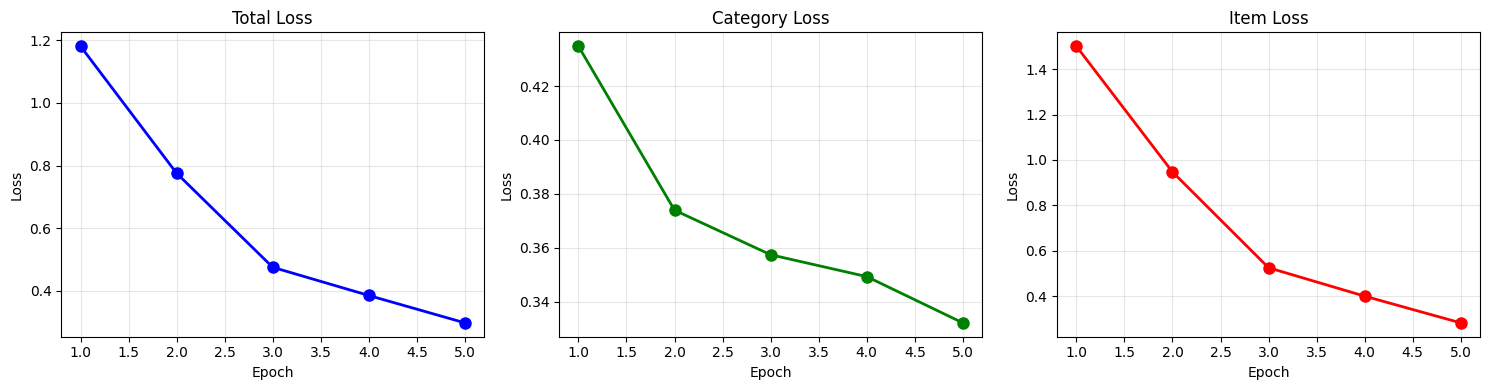

训练曲线已保存到: sampled_data/tdm_training_loss.png


In [ ]:
# 可视化训练过程
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = [h['epoch'] for h in history_losses]
total_losses = [h['loss'] for h in history_losses]
cat_losses = [h['cat_loss'] for h in history_losses]
item_losses = [h['item_loss'] for h in history_losses]

# 总损失
axes[0].plot(epochs, total_losses, 'b-o', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss')
axes[0].grid(True, alpha=0.3)

# 类目损失
axes[1].plot(epochs, cat_losses, 'g-o', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Category Loss')
axes[1].grid(True, alpha=0.3)

# 物品损失
axes[2].plot(epochs, item_losses, 'r-o', linewidth=2, markersize=8)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Item Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sampled_data/tdm_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print("训练曲线已保存到: sampled_data/tdm_training_loss.png")

## 8. TDM Beam Search 推理

训练完成后，使用 Beam Search 进行推荐：
- 从根节点开始，选择 Top-K 类目
- 在选中的类目下，选择 Top-K 物品
- 返回最终的推荐列表

In [ ]:
# TDM Beam Search 推荐
@torch.no_grad()
def tdm_beam_search(model, user_history_indices, all_cat_indices, cat_idx_to_item_indices,
                    device, top_k_categories=20, top_k_items=10):
    """
    TDM Beam Search 推荐
    
    Args:
        model: 训练好的 TDM 模型
        user_history_indices: 用户历史物品索引列表 (已映射)
        all_cat_indices: 所有类目索引列表
        cat_idx_to_item_indices: 类目索引到物品索引的映射
        device: 计算设备
        top_k_categories: 第一层选择的类目数
        top_k_items: 最终返回的物品数
    
    Returns:
        推荐物品索引列表 [(item_idx, score), ...]
    """
    model.eval()
    
    # 准备用户历史
    seq_len = 50
    if len(user_history_indices) < seq_len:
        history = [0] * (seq_len - len(user_history_indices)) + user_history_indices
    else:
        history = user_history_indices[-seq_len:]
    
    history_tensor = torch.LongTensor([history]).to(device)
    
    # 编码用户
    user_repr = model.encode_user(history_tensor)  # [1, hidden_dim]
    
    # === 第一层：选择 Top-K 类目 ===
    cat_tensor = torch.LongTensor([all_cat_indices]).to(device)  # [1, num_categories]
    
    cat_logits = model.predict_category(user_repr, cat_tensor)  # [1, num_categories]
    cat_scores = torch.softmax(cat_logits, dim=-1).squeeze(0)  # [num_categories]
    
    # 选择 Top-K 类目
    top_cat_scores, top_cat_indices = torch.topk(cat_scores, min(top_k_categories, len(all_cat_indices)))
    top_categories = [(all_cat_indices[idx.item()], top_cat_scores[i].item()) 
                      for i, idx in enumerate(top_cat_indices)]
    
    # === 第二层：从 Top 类目中选择物品 ===
    candidate_items = []
    
    for cat_idx, cat_score in top_categories:
        if cat_idx in cat_idx_to_item_indices:
            item_indices = cat_idx_to_item_indices[cat_idx]
            
            if len(item_indices) == 0:
                continue
            
            # 限制每个类目考虑的物品数
            items_to_score = item_indices[:200]
            item_tensor = torch.LongTensor([items_to_score]).to(device)
            
            item_logits = model.predict_item(user_repr, item_tensor)
            item_scores = torch.softmax(item_logits, dim=-1).squeeze(0)
            
            for i, item_idx in enumerate(items_to_score):
                # 综合类目得分和物品得分
                combined_score = cat_score * 0.3 + item_scores[i].item() * 0.7
                candidate_items.append((item_idx, combined_score))
    
    # 排序并返回 Top-K
    candidate_items.sort(key=lambda x: x[1], reverse=True)
    
    # 去重
    seen = set()
    unique_items = []
    for item_idx, score in candidate_items:
        if item_idx not in seen:
            seen.add(item_idx)
            unique_items.append((item_idx, score))
            if len(unique_items) >= top_k_items:
                break
    
    return unique_items

# 使用 dataset 中已构建的映射
all_cat_indices = dataset.all_category_indices
cat_idx_to_item_indices = dataset.cat_idx_to_item_indices
item_idx_to_cat_idx = dataset.item_idx_to_cat_idx

# 测试推荐
print("=" * 60)
print("TDM Beam Search 推荐测试")
print("=" * 60)

# 选择几个测试用户
test_users = df['user_id'].unique()[:5]

for user_id in test_users:
    user_df = df[df['user_id'] == user_id].sort_values('timestamp')
    user_items = user_df['item_id'].tolist()
    
    if len(user_items) < 5:
        continue
    
    # 转换为索引
    user_history_indices = [item_id_to_idx[item_id] for item_id in user_items if item_id in item_id_to_idx]
    
    if len(user_history_indices) < 5:
        continue
    
    # 使用前80%作为历史，后20%作为测试
    split_idx = int(len(user_history_indices) * 0.8)
    history_indices = user_history_indices[:split_idx]
    ground_truth_indices = set(user_history_indices[split_idx:])
    
    # 推荐
    recommendations = tdm_beam_search(
        tdm_model, history_indices, all_cat_indices, cat_idx_to_item_indices,
        device, top_k_categories=20, top_k_items=10
    )
    
    print(f"\n用户 {user_id}:")
    print(f"  历史行为数: {len(history_indices)}")
    print(f"  真实后续行为: {len(ground_truth_indices)} 个物品")
    print(f"  推荐结果:")
    
    hits = 0
    for i, (item_idx, score) in enumerate(recommendations, 1):
        # 转换回原始 item_id
        original_item_id = idx_to_item_id.get(item_idx, item_idx)
        hit = "✓" if item_idx in ground_truth_indices else ""
        if item_idx in ground_truth_indices:
            hits += 1
        print(f"    {i}. Item {original_item_id} (score: {score:.4f}) {hit}")
    
    print(f"  命中数: {hits}/{len(recommendations)}")

TDM Beam Search 推荐测试

用户 100:
  历史行为数: 78
  真实后续行为: 13 个物品
  推荐结果:
    1. Item 3730 (score: 0.3289) 
    2. Item 29564 (score: 0.2532) 
    3. Item 1875 (score: 0.2491) 
    4. Item 87843 (score: 0.1917) 
    5. Item 41897 (score: 0.1738) 
    6. Item 11517 (score: 0.1649) 
    7. Item 44446 (score: 0.1596) 
    8. Item 30489 (score: 0.1222) 
    9. Item 17258 (score: 0.1220) 
    10. Item 13529 (score: 0.1214) 
  命中数: 0/10

用户 1000:
  历史行为数: 64
  真实后续行为: 15 个物品
  推荐结果:
    1. Item 3730 (score: 0.4190) 
    2. Item 29564 (score: 0.2374) 
    3. Item 52487 (score: 0.2018) 
    4. Item 751 (score: 0.1596) 
    5. Item 34333 (score: 0.1596) 
    6. Item 11517 (score: 0.1574) 
    7. Item 44126 (score: 0.1563) 
    8. Item 1875 (score: 0.1365) 
    9. Item 41897 (score: 0.1311) 
    10. Item 13363 (score: 0.1309) 
  命中数: 0/10

用户 1000040:
  历史行为数: 372
  真实后续行为: 78 个物品
  推荐结果:
    1. Item 32339 (score: 0.5152) 
    2. Item 3730 (score: 0.4828) 
    3. Item 52487 (score: 0.3737) 
    4. Item

TDM 模型评估
评估 500 个用户...


评估中: 100%|██████████| 500/500 [01:47<00:00,  4.63it/s]



评估结果:
----------------------------------------
  HitRate@10: 0.0020
  HitRate@20: 0.0040
  HitRate@5: 0.0020
  NDCG@10: 0.0002
  NDCG@20: 0.0002
  NDCG@5: 0.0003
  Recall@10: 0.0001
  Recall@20: 0.0002
  Recall@5: 0.0001
----------------------------------------


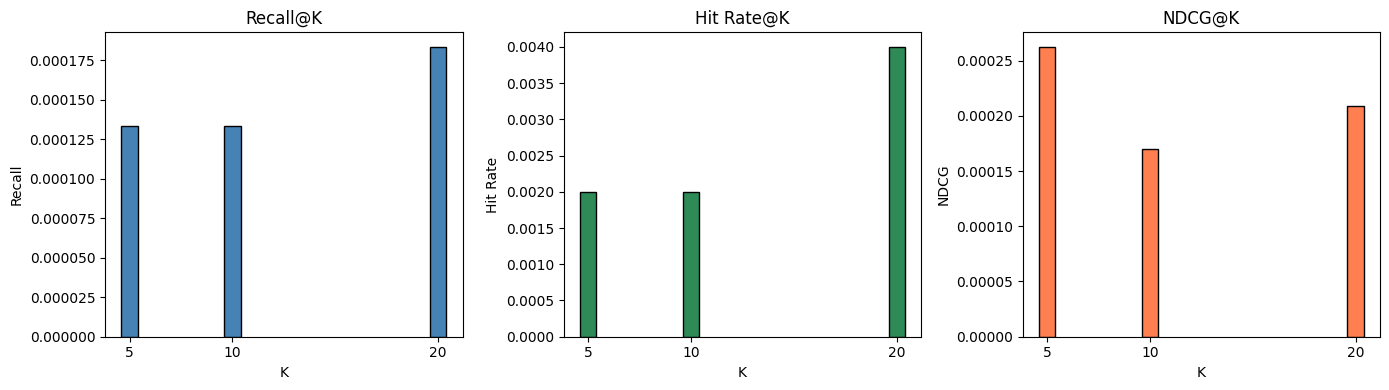


✅ 评估完成! 结果已保存到 sampled_data/tdm_evaluation.png


In [ ]:
# 评估指标计算
from collections import defaultdict

def evaluate_model(model, df, item_id_to_idx, all_cat_indices, cat_idx_to_item_indices,
                   device, num_users=1000, k_list=[5, 10, 20]):
    """
    评估 TDM 模型
    
    指标:
    - Recall@K: 召回率
    - NDCG@K: 归一化折损累积增益
    - Hit Rate@K: 命中率
    """
    model.eval()
    
    metrics = defaultdict(list)
    
    # 随机选择用户
    test_users = df['user_id'].unique()
    if len(test_users) > num_users:
        test_users = np.random.choice(test_users, num_users, replace=False)
    
    print(f"评估 {len(test_users)} 个用户...")
    
    for user_id in tqdm(test_users, desc="评估中"):
        user_df = df[df['user_id'] == user_id].sort_values('timestamp')
        user_items = user_df['item_id'].tolist()
        
        if len(user_items) < 5:
            continue
        
        # 转换为索引
        user_history_indices = [item_id_to_idx[item_id] for item_id in user_items if item_id in item_id_to_idx]
        
        if len(user_history_indices) < 5:
            continue
        
        # 划分历史和测试
        split_idx = int(len(user_history_indices) * 0.8)
        history_indices = user_history_indices[:split_idx]
        ground_truth_indices = set(user_history_indices[split_idx:])
        
        if len(ground_truth_indices) == 0:
            continue
        
        # 推荐
        max_k = max(k_list)
        recommendations = tdm_beam_search(
            model, history_indices, all_cat_indices, cat_idx_to_item_indices,
            device, top_k_categories=30, top_k_items=max_k
        )
        
        rec_items = [item_idx for item_idx, _ in recommendations]
        
        # 计算各 K 值的指标
        for k in k_list:
            rec_k = rec_items[:k]
            
            # Recall@K
            hits = len(set(rec_k) & ground_truth_indices)
            recall = hits / len(ground_truth_indices) if len(ground_truth_indices) > 0 else 0
            metrics[f'Recall@{k}'].append(recall)
            
            # Hit Rate@K (是否至少命中一个)
            hit_rate = 1 if hits > 0 else 0
            metrics[f'HitRate@{k}'].append(hit_rate)
            
            # NDCG@K
            dcg = 0
            for i, item in enumerate(rec_k):
                if item in ground_truth_indices:
                    dcg += 1 / np.log2(i + 2)
            
            # 理想 DCG
            ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(k, len(ground_truth_indices))))
            ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
            metrics[f'NDCG@{k}'].append(ndcg)
    
    # 计算平均值
    results = {}
    for metric_name, values in metrics.items():
        results[metric_name] = np.mean(values)
    
    return results

# 运行评估
print("=" * 60)
print("TDM 模型评估")
print("=" * 60)

eval_results = evaluate_model(
    tdm_model, df, item_id_to_idx, all_cat_indices, cat_idx_to_item_indices, device,
    num_users=500, k_list=[5, 10, 20]
)

print("\n评估结果:")
print("-" * 40)
for metric, value in sorted(eval_results.items()):
    print(f"  {metric}: {value:.4f}")
print("-" * 40)

# 可视化评估结果
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

k_values = [5, 10, 20]

# Recall
recalls = [eval_results[f'Recall@{k}'] for k in k_values]
axes[0].bar(k_values, recalls, color='steelblue', edgecolor='black')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall@K')
axes[0].set_xticks(k_values)

# Hit Rate
hit_rates = [eval_results[f'HitRate@{k}'] for k in k_values]
axes[1].bar(k_values, hit_rates, color='seagreen', edgecolor='black')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Hit Rate')
axes[1].set_title('Hit Rate@K')
axes[1].set_xticks(k_values)

# NDCG
ndcgs = [eval_results[f'NDCG@{k}'] for k in k_values]
axes[2].bar(k_values, ndcgs, color='coral', edgecolor='black')
axes[2].set_xlabel('K')
axes[2].set_ylabel('NDCG')
axes[2].set_title('NDCG@K')
axes[2].set_xticks(k_values)

plt.tight_layout()
plt.savefig('sampled_data/tdm_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 评估完成! 结果已保存到 sampled_data/tdm_evaluation.png")